<a href="https://colab.research.google.com/github/ArTish100/gen-AI-project/blob/main/gen_ai_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cpu
Total Images: 5000
Training Set: 4000
Testing Set: 1000
Starting Training Loop...
[Epoch 1/5] [Batch 0] [D loss: 0.2616] [G loss: 59.7221]
[Epoch 1/5] [Batch 50] [D loss: 0.1413] [G loss: 21.8522]
[Epoch 1/5] [Batch 100] [D loss: 0.0686] [G loss: 19.5333]
[Epoch 2/5] [Batch 0] [D loss: 0.0175] [G loss: 18.6892]
[Epoch 2/5] [Batch 50] [D loss: 0.1681] [G loss: 18.7608]
[Epoch 2/5] [Batch 100] [D loss: 0.2311] [G loss: 18.4092]
[Epoch 3/5] [Batch 0] [D loss: 0.1802] [G loss: 17.1585]
[Epoch 3/5] [Batch 50] [D loss: 0.2002] [G loss: 17.4855]
[Epoch 3/5] [Batch 100] [D loss: 0.0010] [G loss: 16.9066]
[Epoch 4/5] [Batch 0] [D loss: 0.0007] [G loss: 15.6299]
[Epoch 4/5] [Batch 50] [D loss: 0.0006] [G loss: 16.8477]
[Epoch 4/5] [Batch 100] [D loss: 0.0002] [G loss: 15.8858]
[Epoch 5/5] [Batch 0] [D loss: 0.0007] [G loss: 16.5574]
[Epoch 5/5] [Batch 50] [D loss: 0.0007] [G loss: 15.7981]
[Epoch 5/5] [Batch 100] [D loss: 0.0000] [G loss: 16.3191]
Training Finished. Starting Ev

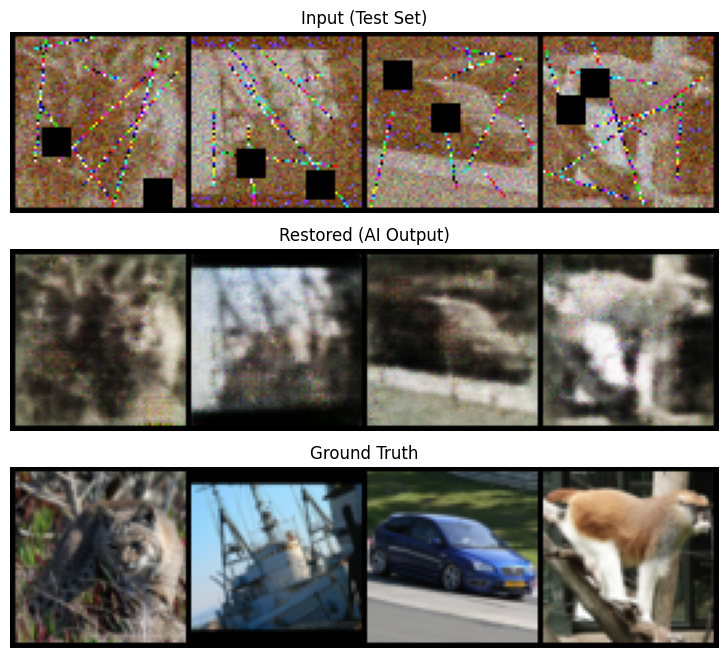

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image, ImageOps
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class SimulateArtifactDamage(object):
    def __init__(self, severity=0.5):
        self.severity = severity

    def __call__(self, img):
        if isinstance(img, torch.Tensor):
            img = transforms.ToPILImage()(img)

        w, h = img.size

        img = ImageOps.colorize(ImageOps.grayscale(img), "#704214", "#C0C0C0")

        from PIL import ImageDraw
        draw = ImageDraw.Draw(img)
        for _ in range(int(10 * self.severity)):
            x1, y1 = random.randint(0, w), random.randint(0, h)
            x2, y2 = random.randint(0, w), random.randint(0, h)
            color = random.choice(['white', 'black'])
            draw.line((x1, y1, x2, y2), fill=color, width=1)

        img_np = np.array(img)
        noise = np.random.normal(0, 25 * self.severity, img_np.shape).astype(np.uint8)
        img_np = np.clip(img_np + noise, 0, 255)
        img = Image.fromarray(img_np)

        draw = ImageDraw.Draw(img)
        for _ in range(int(3 * self.severity)):
            x = random.randint(0, w-10)
            y = random.randint(0, h-10)
            draw.rectangle([x, y, x+10, y+10], fill='black')

        return transforms.ToTensor()(img)

transform_clean = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

class PairedDataset(torch.utils.data.Dataset):
    def __init__(self, root='./data', split='train', download=True):
        self.base_data = datasets.STL10(root=root, split=split, download=download, transform=None)
        self.damage_simulator = SimulateArtifactDamage(severity=0.8)
        self.clean_transform = transform_clean

    def __len__(self):
        return len(self.base_data)

    def __getitem__(self, index):
        clean_pil_original, _ = self.base_data[index]
        resized_pil = transforms.Resize((64, 64))(clean_pil_original)
        real_img = self.clean_transform(resized_pil)
        damaged_img_tensor = self.damage_simulator(resized_pil)
        damaged_img = (damaged_img_tensor - 0.5) / 0.5
        return damaged_img, real_img

full_dataset = PairedDataset()

train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Total Images: {len(full_dataset)}")
print(f"Training Set: {len(train_dataset)}")
print(f"Testing Set: {len(test_dataset)}")

class GeneratorUNet(nn.Module):
    def __init__(self):
        super(GeneratorUNet, self).__init__()

        def down_block(in_feat, out_feat, normalize=True):
            layers = [nn.Conv2d(in_feat, out_feat, 4, 2, 1, bias=False)]
            if normalize: layers.append(nn.BatchNorm2d(out_feat))
            layers.append(nn.LeakyReLU(0.2))
            return nn.Sequential(*layers)

        def up_block(in_feat, out_feat, dropout=0.0):
            layers = [nn.ConvTranspose2d(in_feat, out_feat, 4, 2, 1, bias=False),
                      nn.BatchNorm2d(out_feat),
                      nn.ReLU()]
            if dropout: layers.append(nn.Dropout(dropout))
            return nn.Sequential(*layers)

        self.down1 = down_block(3, 64, normalize=False)
        self.down2 = down_block(64, 128)
        self.down3 = down_block(128, 256)
        self.down4 = down_block(256, 512)

        self.up1 = up_block(512, 256)
        self.up2 = up_block(512, 128)
        self.up3 = up_block(256, 64)

        self.final = nn.Sequential(
            nn.ConvTranspose2d(128, 3, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        u1 = self.up1(d4)
        u2 = self.up2(torch.cat([u1, d3], 1))
        u3 = self.up3(torch.cat([u2, d2], 1))
        return self.final(torch.cat([u3, d1], 1))

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, normalization=True):
            layers = [nn.Conv2d(in_filters, out_filters, 4, 2, 1)]
            if normalization: layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return nn.Sequential(*layers)

        self.model = nn.Sequential(
            discriminator_block(6, 64, normalization=False),
            discriminator_block(64, 128),
            discriminator_block(128, 256),
            nn.Conv2d(256, 1, 4, 1, 0),
            nn.Sigmoid()
        )

    def forward(self, img_A, img_B):
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)

generator = GeneratorUNet().to(device)
discriminator = Discriminator().to(device)

criterion_GAN = nn.MSELoss()
criterion_pixel = nn.L1Loss()

optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

num_epochs = 5
lambda_pixel = 100

print("Starting Training Loop...")

for epoch in range(num_epochs):
    for i, (damaged, real) in enumerate(train_loader):
        damaged = damaged.to(device)
        real = real.to(device)

        optimizer_G.zero_grad()
        fake = generator(damaged)
        pred_fake = discriminator(damaged, fake)
        loss_GAN = criterion_GAN(pred_fake, torch.ones_like(pred_fake))
        loss_pixel = criterion_pixel(fake, real)
        loss_G = loss_GAN + (lambda_pixel * loss_pixel)
        loss_G.backward()
        optimizer_G.step()

        optimizer_D.zero_grad()
        pred_real = discriminator(damaged, real)
        loss_real = criterion_GAN(pred_real, torch.ones_like(pred_real))
        pred_fake = discriminator(damaged, fake.detach())
        loss_fake = criterion_GAN(pred_fake, torch.zeros_like(pred_fake))
        loss_D = 0.5 * (loss_real + loss_fake)
        loss_D.backward()
        optimizer_D.step()

        if i % 50 == 0:
            print(f"[Epoch {epoch+1}/{num_epochs}] [Batch {i}] [D loss: {loss_D.item():.4f}] [G loss: {loss_G.item():.4f}]")

print("Training Finished. Starting Evaluation on Test Set...")

def evaluate_and_visualize():
    generator.eval()
    total_psnr = 0.0
    total_ssim = 0.0
    num_batches = 0

    with torch.no_grad():
        for i, (damaged, real) in enumerate(test_loader):
            damaged = damaged.to(device)
            real = real.to(device)
            fake = generator(damaged)

            real_np = (real.cpu().numpy() * 0.5 + 0.5).clip(0, 1)
            fake_np = (fake.cpu().numpy() * 0.5 + 0.5).clip(0, 1)

            batch_psnr = 0.0
            batch_ssim = 0.0

            for j in range(real_np.shape[0]):
                r_img = np.transpose(real_np[j], (1, 2, 0))
                f_img = np.transpose(fake_np[j], (1, 2, 0))
                batch_psnr += psnr(r_img, f_img, data_range=1.0)
                batch_ssim += ssim(r_img, f_img, data_range=1.0, channel_axis=2)

            total_psnr += batch_psnr / real_np.shape[0]
            total_ssim += batch_ssim / real_np.shape[0]
            num_batches += 1

    print(f"Test Set Average PSNR: {total_psnr / num_batches:.2f}")
    print(f"Test Set Average SSIM: {total_ssim / num_batches:.4f}")

    with torch.no_grad():
        damaged, real = next(iter(test_loader))
        damaged = damaged.to(device)
        real = real.to(device)
        fake = generator(damaged)

        damaged = damaged.cpu()
        real = real.cpu()
        fake = fake.cpu()

        img_grid_damaged = vutils.make_grid(damaged[:4], nrow=4, normalize=True)
        img_grid_fake = vutils.make_grid(fake[:4], nrow=4, normalize=True)
        img_grid_real = vutils.make_grid(real[:4], nrow=4, normalize=True)

        plt.figure(figsize=(15, 8))
        plt.subplot(3, 1, 1)
        plt.axis("off")
        plt.title("Input (Test Set)")
        plt.imshow(np.transpose(img_grid_damaged, (1, 2, 0)))

        plt.subplot(3, 1, 2)
        plt.axis("off")
        plt.title("Restored (AI Output)")
        plt.imshow(np.transpose(img_grid_fake, (1, 2, 0)))

        plt.subplot(3, 1, 3)
        plt.axis("off")
        plt.title("Ground Truth")
        plt.imshow(np.transpose(img_grid_real, (1, 2, 0)))
        plt.show()

evaluate_and_visualize()